In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
import os
import django
from asgiref.sync import sync_to_async
import pandas as pd
from univ.models import University

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "universityrec.settings")
django.setup()

# Define a function to asynchronously fetch queryset
@sync_to_async
def get_university_queryset():
    return list(University.objects.filter(country='US', course='CE/CS'))

# Call the function to fetch the queryset asynchronously
queryset = await get_university_queryset()

# Print the queryset to check if it contains any data
print(queryset)

# Construct a dictionary from the queryset
data = {
    'GRE Score': [entry.GREscore for entry in queryset],
    'GPA': [entry.GPA for entry in queryset],
    'IELTS Score': [entry.IELTSscore for entry in queryset],
    'Research Paper': [entry.ResearchPaper for entry in queryset],
    'University Ranking': [entry.UniversityRanking for entry in queryset],
    'University Name': [entry.UniversityName for entry in queryset],
    'Admit Probability': [entry.AdmitProbability for entry in queryset]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Optionally, set University Name as the index
df.set_index('University Name', inplace=True)

# Display the DataFrame
print(df)


ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

In [ ]:
df=pd.read_csv('university_data.csv')
df

,GRE Score,GPA,IELTS Score,Research Paper,University Ranking,University Name,Admit Probability
0,51,0.5,3.7,55,77,California Institute of Technology (Caltech),0.62
1,163,1.0,8.0,45,66,Los Angeles (UCLA),0.11
2,176,1.2,4.9,7,83,University of Rochester,0.22
3,145,1.7,4.3,37,67,University of Notre Dame,0.58
4,44,2.2,2.3,5,55,University of Virginia,0.04
...,...,...,...,...,...,...,...
995,254,0.2,2.7,18,88,Irvine (UCI),0.94
996,301,0.9,7.3,4,66,University of Pennsylvania,0.50
997,232,1.5,2.3,64,24,University of Iowa,0.30
998,142,2.3,8.2,79,11,Florida State University,0.25


In [ ]:
df['University Name'].nunique()

KeyError: 'University Name'

In [ ]:
df.shape

(1000, 7)

In [ ]:
def righter(data):
    data=data%10
    return data

df['Research Paper']=df['Research Paper'].apply(righter)

In [ ]:
df['Research Paper'].unique()

array([5, 7, 4, 0, 6, 2, 8, 3, 9, 1], dtype=int64)

In [ ]:
X = df.drop(['University Name', 'Admit Probability','University Ranking'], axis=1)
y_binary = (df['Admit Probability'] >= 0.8).astype(int)

In [ ]:
# Convert to binary classification based on a threshold (e.g., 0.8)
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(df['University Name'])

In [ ]:
numerical_features = ['GRE Score', 'GPA', 'IELTS Score', 'University Ranking']
categorical_features = []  # Since 'Research Experience' is dropped

In [ ]:
X_train, X_test, y_train_binary, y_test_binary, y_train_label_encoded, y_test_label_encoded = train_test_split(
    X, y_binary, y_label_encoded, test_size=0.2, random_state=42
)

In [ ]:
X_train

,GRE Score,GPA,IELTS Score,Research Paper
29,255,1.2,1.7,0
535,9,1.2,5.6,8
695,92,2.5,6.5,5
557,135,3.3,1.2,5
836,157,1.3,8.1,9
...,...,...,...,...
106,143,1.1,2.4,5
270,137,3.4,5.6,0
860,325,3.1,7.0,1
435,44,0.3,8.8,1


In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2,3, 10, 20],
    'min_samples_split': [10,14],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=3)
rf_grid.fit(X_train, y_train_label_encoded)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10, 14],
                         'n_estimators': [50, 100, 200]})

In [ ]:
rf_grid.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

In [ ]:
y_pred_rf = rf_grid.predict(X_test)
accuracy_rf = accuracy_score(y_test_binary, y_pred_rf)
print("RandomForestClassifier Accuracy:", accuracy_rf)

RandomForestClassifier Accuracy: 0.0


In [ ]:
# with open('random_forest_model.pkl', 'wb') as rf_file:
#     pickle.dump(rf_grid.best_estimator_, rf_file)

In [ ]:
xgb_param_grid = {
    'n_estimators': [35,40,45,50],
    'max_depth': [2,3,4],
    'learning_rate': [0.007,0.008,0.009]
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42), param_grid=xgb_param_grid, cv=3)
xgb_grid.fit(X_train, y_train_label_encoded)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.007, 0.008, 0.009],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [35, 40, 45, 50]})

In [ ]:
X_train

,GRE Score,GPA,IELTS Score,Research Paper
29,255,1.2,1.7,0
535,9,1.2,5.6,8
695,92,2.5,6.5,5
557,135,3.3,1.2,5
836,157,1.3,8.1,9
...,...,...,...,...
106,143,1.1,2.4,5
270,137,3.4,5.6,0
860,325,3.1,7.0,1
435,44,0.3,8.8,1


In [ ]:
y_train_label_encoded

array([44, 17, 65,  3, 29, 52,  7, 51,  4, 25, 50, 16, 74, 14, 30, 17, 21,
       23, 17, 44, 29, 30, 60, 25, 38, 66,  0, 28, 16, 52, 68,  2, 38, 44,
       17, 63,  1, 50, 43,  2, 61, 12, 45, 65, 18, 44,  0,  5, 14, 44, 40,
       32, 32, 67, 71, 44, 30, 18, 43, 45, 44, 64, 22, 22, 76, 55, 66, 54,
        8,  0, 44, 57, 44, 44, 65, 21, 57, 13, 72, 30, 38, 44, 50, 64, 63,
       10,  6, 61, 37, 32, 12, 62,  2, 63, 49, 65,  4, 12, 29,  5, 24,  7,
       55, 44, 62, 34, 45, 12, 67,  2, 57, 13, 12, 51,  6, 63, 22, 31, 68,
       48, 74, 72,  5, 31, 44, 11, 74,  0,  2, 58, 15,  6, 44, 64,  5, 32,
       63, 33, 24, 52, 31, 26, 71, 24,  6, 27, 27, 60, 67, 13, 35, 16, 40,
       45, 66,  7,  2, 35, 42, 34, 20, 41, 40, 43, 54, 62, 67, 18, 20, 62,
       48, 24, 52, 40,  8, 13, 36, 21, 39, 59, 21, 76, 33, 37, 55, 60, 28,
       49, 38, 39, 12, 27, 31, 47, 44, 22, 55, 29, 41, 52, 21, 46, 19, 26,
       71,  8, 24,  1, 50, 18, 16,  1, 44, 54,  2, 38,  1, 47,  6, 44, 47,
       73, 55, 11, 44, 33

In [ ]:
xgb_grid.best_params_

{'learning_rate': 0.007, 'max_depth': 2, 'n_estimators': 35}

In [ ]:
xgb_grid.best_score_

0.08749870932011676

In [ ]:
catboost_param_grid = {
    'iterations': [45,50,55],
    'depth': [4,5, 6],
    'learning_rate': [0.009,0.01, 0.1]
}

catboost_grid = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid=catboost_param_grid, cv=3)
catboost_grid.fit(X_train, y_train_label_encoded)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001DA66329BD0>,
             param_grid={'depth': [4, 5, 6], 'iterations': [45, 50, 55],
                         'learning_rate': [0.009, 0.01, 0.1]})

In [ ]:
y_train_label_encoded

array([44, 17, 65,  3, 29, 52,  7, 51,  4, 25, 50, 16, 74, 14, 30, 17, 21,
       23, 17, 44, 29, 30, 60, 25, 38, 66,  0, 28, 16, 52, 68,  2, 38, 44,
       17, 63,  1, 50, 43,  2, 61, 12, 45, 65, 18, 44,  0,  5, 14, 44, 40,
       32, 32, 67, 71, 44, 30, 18, 43, 45, 44, 64, 22, 22, 76, 55, 66, 54,
        8,  0, 44, 57, 44, 44, 65, 21, 57, 13, 72, 30, 38, 44, 50, 64, 63,
       10,  6, 61, 37, 32, 12, 62,  2, 63, 49, 65,  4, 12, 29,  5, 24,  7,
       55, 44, 62, 34, 45, 12, 67,  2, 57, 13, 12, 51,  6, 63, 22, 31, 68,
       48, 74, 72,  5, 31, 44, 11, 74,  0,  2, 58, 15,  6, 44, 64,  5, 32,
       63, 33, 24, 52, 31, 26, 71, 24,  6, 27, 27, 60, 67, 13, 35, 16, 40,
       45, 66,  7,  2, 35, 42, 34, 20, 41, 40, 43, 54, 62, 67, 18, 20, 62,
       48, 24, 52, 40,  8, 13, 36, 21, 39, 59, 21, 76, 33, 37, 55, 60, 28,
       49, 38, 39, 12, 27, 31, 47, 44, 22, 55, 29, 41, 52, 21, 46, 19, 26,
       71,  8, 24,  1, 50, 18, 16,  1, 44, 54,  2, 38,  1, 47,  6, 44, 47,
       73, 55, 11, 44, 33

In [ ]:
catboost_grid.best_params_

{'depth': 4, 'iterations': 45, 'learning_rate': 0.009}

In [ ]:
catboost_grid.best_score_

0.09999718397116386

In [ ]:
with open('modelUS.pkl', 'wb') as xgb_file:
    pickle.dump(catboost_grid.best_estimator_, xgb_file)

In [ ]:


with open('label_encoderUS.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

In [ ]:
df = pd.read_csv('university_data.csv')

# Data Exploration and Visualization

# Exclude non-numeric columns before creating the correlation heatmap
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_df = df[numeric_columns]

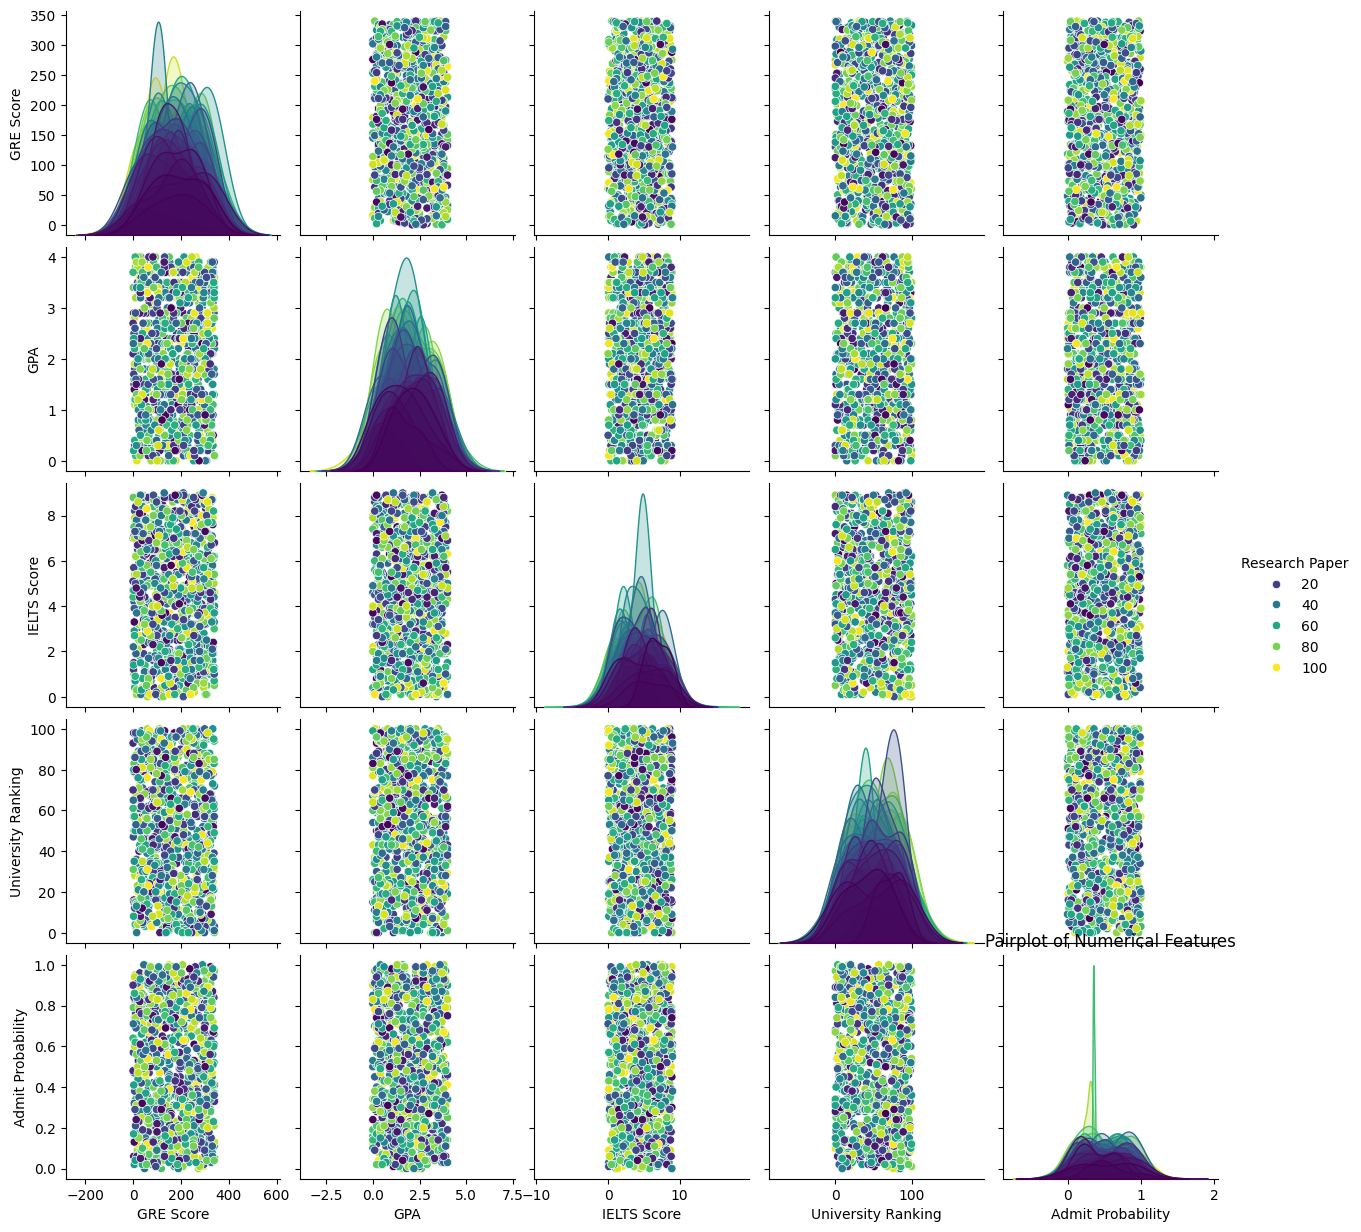

In [ ]:
sns.pairplot(df, hue='Research Paper', palette='viridis')
plt.title('Pairplot of Numerical Features')
plt.show()

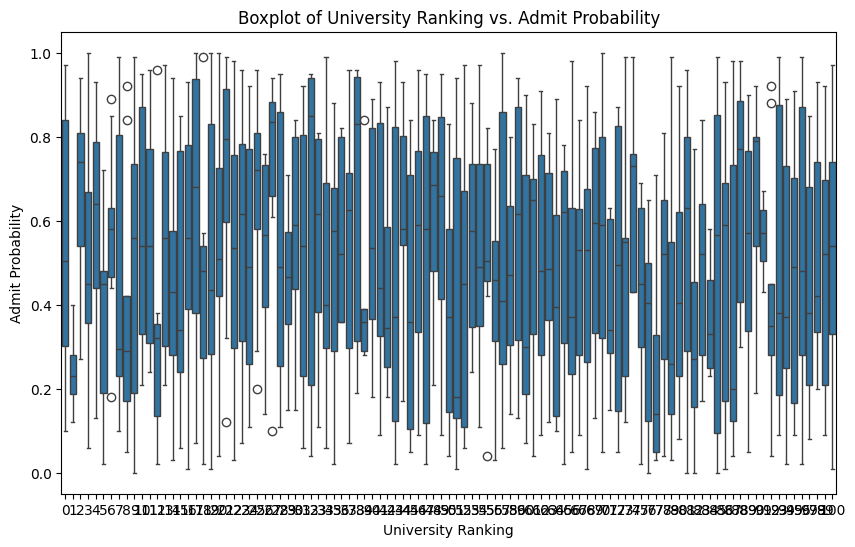

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='University Ranking', y='Admit Probability', data=df)
plt.title('Boxplot of University Ranking vs. Admit Probability')
plt.show()

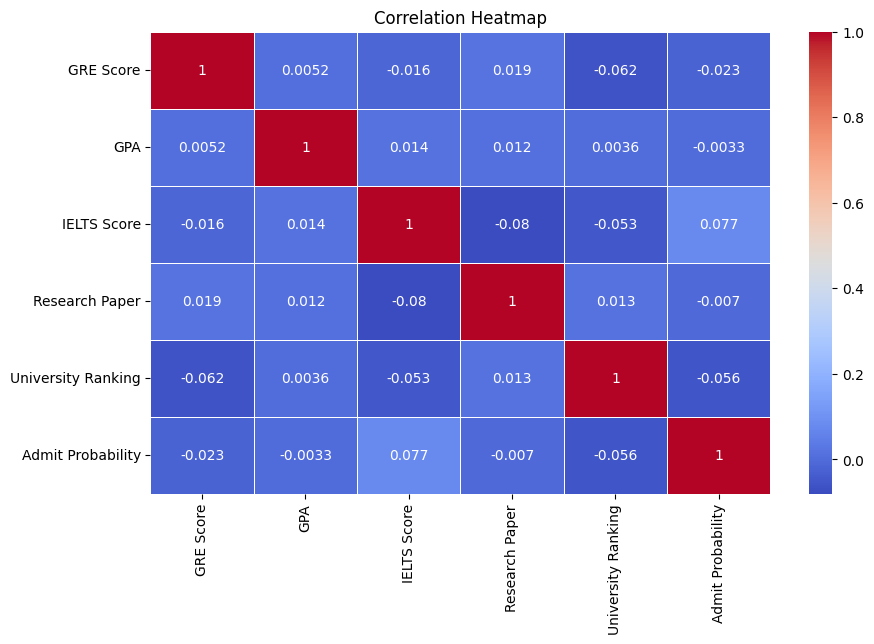

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


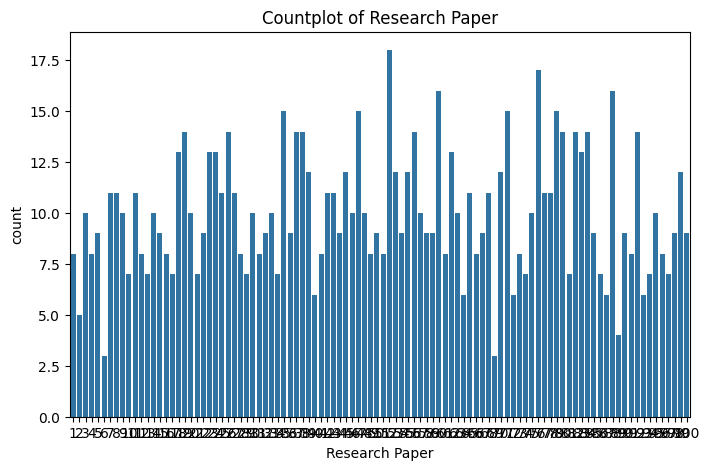

In [ ]:
# Countplot for Research Experience
plt.figure(figsize=(8, 5))
sns.countplot(x='Research Paper', data=df)
plt.title('Countplot of Research Paper')
plt.show() 